# Tutorial 4 — Multi-Factor Alpha Composition

## Overview

Individual alpha signals — momentum, reversal, low-volatility, quality —
each capture a different dimension of cross-sectional return predictability.
No single signal dominates in all market regimes.

Combining signals into a **composite alpha** can:
- **Diversify** across signal-specific risk (a momentum crash does not coincide with a vol regime shift).
- **Stabilise** performance across market regimes.
- **Increase capacity** by spreading bets more evenly across the universe.

This tutorial covers:
1. Signal computation and normalisation.
2. Cross-sectional signal correlation analysis.
3. Three combination methods: equal-weight, IC-weighted, rank-then-combine.
4. Backtesting all individual and composite strategies.
5. Marginal contribution analysis (leave-one-out).
6. Correlation stability over time.
7. What can go wrong — overfitting, common exposures, correlation breakdown.
8. Summary.

## 1. Setup and data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

plt.rcParams.update({"figure.figsize": (12, 5), "figure.dpi": 100,
                     "axes.grid": True, "grid.alpha": 0.3})

from qlab.data import YFinanceProvider, ParquetCache
from qlab.features import simple_returns, rank, zscore, winsorize, demean, realized_volatility
from qlab.alphas import momentum, short_term_reversal, low_volatility, profitability_proxy
from qlab.portfolio import equal_weight_long_short, proportional_weights, normalize_weights, apply_position_limits
from qlab.backtest import run_backtest, BacktestConfig
from qlab.risk import performance_summary, drawdown_series, factor_regression
from scipy.stats import spearmanr

TICKERS = [
    "AAPL", "MSFT", "GOOG", "AMZN", "META",
    "JPM", "GS", "BAC",
    "JNJ", "PFE", "UNH",
    "XOM", "CVX",
    "PG", "KO", "WMT",
    "HD", "NKE",
    "CAT", "HON",
]
START, END = "2018-01-01", "2024-12-31"

provider = ParquetCache(YFinanceProvider(), cache_dir=".qlab_cache")
prices = provider.fetch(TICKERS, START, END)
close = prices["adj_close"]
print(f"Universe : {close.index.get_level_values('ticker').nunique()} stocks")
print(f"Date range: {close.index.get_level_values('date').min().date()} to "
      f"{close.index.get_level_values('date').max().date()}")
print(f"Total obs : {len(close):,}")

Universe : 20 stocks
Date range: 2018-01-02 to 2024-12-30
Total obs : 35,200


## 2. Compute individual alpha signals

We construct four signals spanning different return drivers:

| Signal | Function | Lookback | Intuition |
|--------|----------|----------|-----------|
| **Momentum** | `momentum(close, 252, 21)` | 12 months, skip 1 month | Winners keep winning |
| **Short-term reversal** | `short_term_reversal(close, 21)` | 1 month | Recent losers bounce back |
| **Low volatility** | `low_volatility(close, 126)` | 6 months | Calm stocks outperform |
| **Profitability proxy** | `profitability_proxy(close, 252)` | 12 months | High risk-adjusted return signals quality |

Each raw signal is normalised via `zscore(winsorize(...))` to put them on a
comparable scale and tame outliers before combination.

In [2]:
# Compute raw signals
sig_mom_raw = momentum(close, lookback=252, skip=21)
sig_rev_raw = short_term_reversal(close, lookback=21)
sig_vol_raw = low_volatility(close, lookback=126)
sig_prof_raw = profitability_proxy(close, lookback=252)

# Normalise: winsorise at 5th/95th percentile, then cross-sectional z-score
sig_mom = zscore(winsorize(sig_mom_raw.dropna(), lower=0.05, upper=0.95))
sig_rev = zscore(winsorize(sig_rev_raw.dropna(), lower=0.05, upper=0.95))
sig_vol = zscore(winsorize(sig_vol_raw.dropna(), lower=0.05, upper=0.95))
sig_prof = zscore(winsorize(sig_prof_raw.dropna(), lower=0.05, upper=0.95))

# Align all signals on a common (date, ticker) index
signals = {"Momentum": sig_mom, "Reversal": sig_rev,
           "LowVol": sig_vol, "Profitability": sig_prof}
common_idx = sig_mom.dropna().index
for s in signals.values():
    common_idx = common_idx.intersection(s.dropna().index)

signals = {name: sig.reindex(common_idx) for name, sig in signals.items()}
sig_df = pd.DataFrame(signals)

print(f"Common index: {sig_df.index.get_level_values('date').nunique()} dates, "
      f"{sig_df.index.get_level_values('ticker').nunique()} tickers, "
      f"{len(sig_df):,} observations")
print(f"Date range: {sig_df.index.get_level_values('date').min().date()} to "
      f"{sig_df.index.get_level_values('date').max().date()}")
print("\nSignal summary statistics:")
print(sig_df.describe().round(3).to_string())

Common index: 1508 dates, 20 tickers, 30,160 observations
Date range: 2019-01-03 to 2024-12-30

Signal summary statistics:
        Momentum   Reversal     LowVol  Profitability
count  30160.000  30160.000  30160.000      30160.000
mean       0.000      0.000      0.000          0.000
std        0.975      0.975      0.975          0.975
min       -2.272     -2.449     -2.455         -2.407
25%       -0.735     -0.716     -0.675         -0.746
50%       -0.100      0.041      0.042         -0.017
75%        0.666      0.729      0.760          0.744
max        2.491      2.393      1.901          2.272


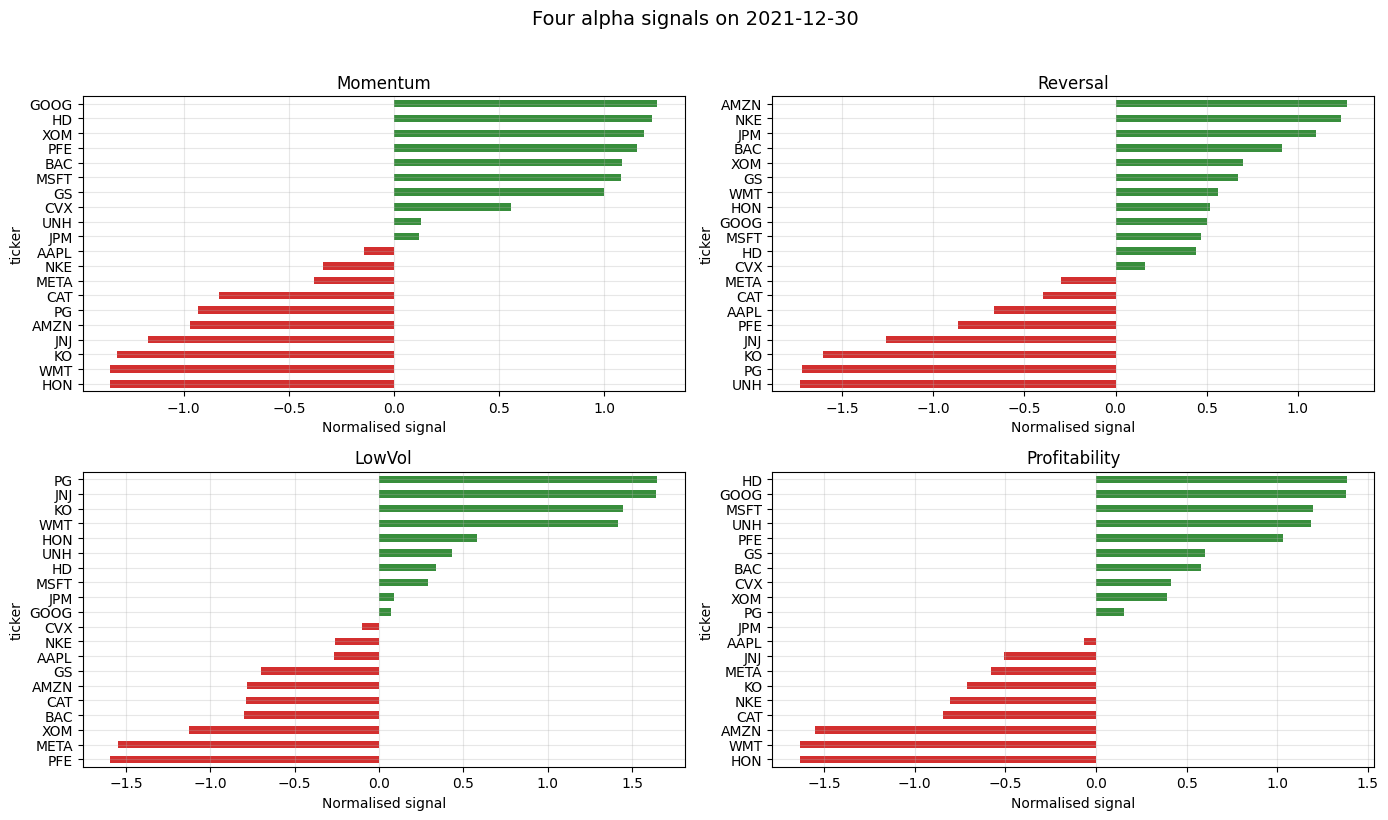

In [3]:
# Visualise the four signals on a sample date
sample_date = sig_df.index.get_level_values("date").unique()[
    len(sig_df.index.get_level_values("date").unique()) // 2
]
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
for ax, (name, sig) in zip(axes.flat, signals.items()):
    vals = sig.loc[sample_date].sort_values()
    colors = ["#d32f2f" if v < 0 else "#388e3c" for v in vals.values]
    vals.plot.barh(ax=ax, color=colors)
    ax.set_title(name)
    ax.set_xlabel("Normalised signal")
fig.suptitle(f"Four alpha signals on {sample_date.date()}", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 3. Signal correlation analysis

Low correlation between signals is the prerequisite for diversification.
We compute the **average cross-sectional Spearman rank correlation** between
all signal pairs.

| Correlation range | Implication |
|-------------------|-------------|
| > 0.5 | Highly redundant; combining adds little |
| 0.1 to 0.5 | Moderate overlap; combination beneficial |
| -0.3 to 0.1 | Low/negative; excellent diversification |
| < -0.3 | Strongly opposing; check for cancellation |

In [4]:
signal_names = list(signals.keys())
n_signals = len(signal_names)
dates = sig_df.index.get_level_values("date").unique()

# Compute average cross-sectional Spearman correlation between all pairs
corr_matrix = np.zeros((n_signals, n_signals))
for i in range(n_signals):
    for j in range(n_signals):
        if i == j:
            corr_matrix[i, j] = 1.0
            continue
        corrs = []
        for d in dates[::5]:  # sample every 5th date for speed
            s_i = signals[signal_names[i]].loc[d].dropna()
            s_j = signals[signal_names[j]].loc[d].dropna()
            common_tickers = s_i.index.intersection(s_j.index)
            if len(common_tickers) >= 5:
                rho, _ = spearmanr(s_i.loc[common_tickers].values,
                                   s_j.loc[common_tickers].values)
                if not np.isnan(rho):
                    corrs.append(rho)
        corr_matrix[i, j] = np.mean(corrs) if corrs else 0.0

corr_df = pd.DataFrame(corr_matrix, index=signal_names, columns=signal_names)
print("Average cross-sectional Spearman correlation:")
print(corr_df.round(3).to_string())
print(f"\nAverage off-diagonal correlation: "
      f"{(corr_matrix.sum() - n_signals) / (n_signals * (n_signals - 1)):.3f}")

Average cross-sectional Spearman correlation:
               Momentum  Reversal  LowVol  Profitability
Momentum          1.000    -0.023   0.028          0.903
Reversal         -0.023     1.000   0.050         -0.260
LowVol            0.028     0.050   1.000          0.130
Profitability     0.903    -0.260   0.130          1.000

Average off-diagonal correlation: 0.138


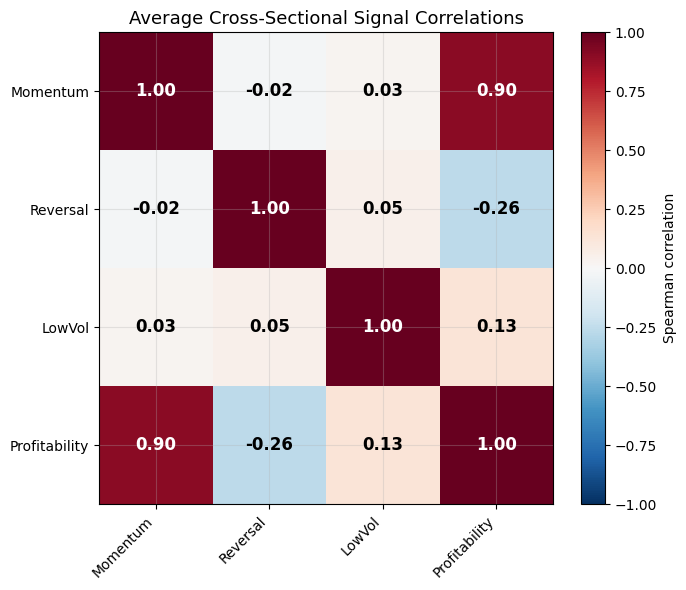

In [5]:
# Correlation heatmap with annotated values
fig, ax = plt.subplots(figsize=(7, 6))
im = ax.imshow(corr_matrix, cmap="RdBu_r", vmin=-1, vmax=1, aspect="auto")
ax.set_xticks(range(n_signals))
ax.set_xticklabels(signal_names, rotation=45, ha="right")
ax.set_yticks(range(n_signals))
ax.set_yticklabels(signal_names)

for i in range(n_signals):
    for j in range(n_signals):
        color = "white" if abs(corr_matrix[i, j]) > 0.5 else "black"
        ax.text(j, i, f"{corr_matrix[i, j]:.2f}",
                ha="center", va="center", color=color, fontsize=12, fontweight="bold")

plt.colorbar(im, ax=ax, label="Spearman correlation")
ax.set_title("Average Cross-Sectional Signal Correlations", fontsize=13)
plt.tight_layout()
plt.show()

## 4. Combination methods

### Method A — Equal-weight z-score average

The simplest approach: average the normalised signals with equal weight.
No look-ahead bias, fully out-of-sample. This is the baseline that any
fancier method must beat.

$$\alpha_i^{\text{EW}} = \frac{1}{K} \sum_{k=1}^{K} z_{ik}$$

### Method B — IC-weighted average

Weight each signal by its trailing **Information Coefficient** (cross-sectional
Spearman rank correlation with 21-day forward returns). Signals with higher
predictive power get more weight. We shrink the IC weights 50% toward equal
weight to reduce estimation noise.

### Method C — Rank-then-combine

Rank each signal into cross-sectional percentiles first, then average the
ranks. This is robust to outliers and ensures each signal contributes
equally regardless of distribution shape.

In [6]:
# ── Method A: Equal-weight average ──
combo_ew = sig_df.mean(axis=1)
combo_ew = zscore(combo_ew.dropna())
combo_ew.name = "EqualWeight"

print("Method A: Equal-weight composite")
print(f"  Observations: {len(combo_ew.dropna()):,}")
print(f"  Cross-sectional std (mean): {combo_ew.groupby(level='date').std().mean():.3f}")

Method A: Equal-weight composite
  Observations: 30,160
  Cross-sectional std (mean): 1.000


In [7]:
# ── Method B: IC-weighted combination ──
# Compute 21-day forward returns for IC calculation
fwd_ret = simple_returns(close, periods=21).groupby(level="ticker").shift(-21)
fwd_ret = fwd_ret.reindex(common_idx)

# Compute trailing IC per signal using a 126-day expanding window
# Sample every 5th date, subsample trailing dates for efficiency
ic_window = 126
ic_series = {name: [] for name in signal_names}
ic_date_list = []

for d_idx in range(ic_window, len(dates), 5):
    d = dates[d_idx]
    trail_dates = dates[max(0, d_idx - ic_window):d_idx]
    for name in signal_names:
        ics = []
        for td in trail_dates[::3]:
            try:
                sig_d = signals[name].loc[td].dropna()
                fwd_d = fwd_ret.loc[td].dropna()
                common_t = sig_d.index.intersection(fwd_d.index)
                if len(common_t) >= 5:
                    rho, _ = spearmanr(sig_d.loc[common_t].values,
                                       fwd_d.loc[common_t].values)
                    if not np.isnan(rho):
                        ics.append(rho)
            except Exception:
                continue
        ic_series[name].append(np.mean(ics) if ics else 0.0)
    ic_date_list.append(d)

ic_df = pd.DataFrame(ic_series, index=ic_date_list)
print("Trailing IC statistics:")
print(ic_df.describe().round(4).to_string())

Trailing IC statistics:
       Momentum  Reversal    LowVol  Profitability
count  277.0000  277.0000  277.0000       277.0000
mean     0.0190   -0.0025   -0.0585         0.0108
std      0.1058    0.0919    0.1299         0.1084
min     -0.2766   -0.2110   -0.3360        -0.3010
25%     -0.0383   -0.0743   -0.1574        -0.0378
50%      0.0305   -0.0079   -0.0558         0.0282
75%      0.1012    0.0639    0.0689         0.0965
max      0.2182    0.2124    0.2228         0.1992


In [8]:
# Build IC-weighted composite with 50% shrinkage toward equal weight
shrinkage = 0.5
equal_w = 1.0 / n_signals

# Interpolate IC weights to all dates, then shrink
ic_weights_full = ic_df.reindex(dates).interpolate(method="index").ffill().bfill()
# Clip negative ICs to zero before weighting
ic_weights_pos = ic_weights_full.clip(lower=0)
# Normalise so weights sum to 1 (or equal weight if all zero)
row_sums = ic_weights_pos.sum(axis=1)
ic_weights_norm = ic_weights_pos.div(row_sums.replace(0, np.nan), axis=0).fillna(equal_w)
# Shrink toward equal weight
ic_weights_shrunk = shrinkage * equal_w + (1 - shrinkage) * ic_weights_norm

# Build composite signal date by date
combo_ic_parts = []
combo_ic_keys = []
for d in dates:
    if d not in ic_weights_shrunk.index:
        continue
    w = ic_weights_shrunk.loc[d]
    if d in sig_df.index.get_level_values("date"):
        sig_d = sig_df.loc[d]
        if not sig_d.empty:
            combined = (sig_d * w.values).sum(axis=1)
            combo_ic_parts.append(combined)
            combo_ic_keys.append(d)

combo_ic = pd.concat(combo_ic_parts, keys=combo_ic_keys, names=["date", "ticker"])
combo_ic = zscore(combo_ic.dropna())
combo_ic.name = "ICWeighted"

print("Method B: IC-weighted composite (50% shrinkage)")
print(f"  Observations: {len(combo_ic.dropna()):,}")
print(f"\nShrunk IC weights (last available date):")
last_w = ic_weights_shrunk.iloc[-1]
for name, w in last_w.items():
    print(f"  {name:15s}: {w:.3f}")

Method B: IC-weighted composite (50% shrinkage)
  Observations: 30,160

Shrunk IC weights (last available date):
  Momentum       : 0.379
  Reversal       : 0.214
  LowVol         : 0.125
  Profitability  : 0.283


In [9]:
# ── Method C: Rank-then-combine ──
ranked_signals = {name: rank(sig) for name, sig in signals.items()}
rank_df = pd.DataFrame(ranked_signals)
combo_rank = rank_df.mean(axis=1)
combo_rank = zscore(combo_rank.dropna())
combo_rank.name = "RankCombo"

print("Method C: Rank-then-combine composite")
print(f"  Observations: {len(combo_rank.dropna()):,}")

Method C: Rank-then-combine composite
  Observations: 30,160


## 5. Backtest all strategies

We backtest all 7 strategies (4 individual + 3 composite) with identical
portfolio construction: quintile long/short, dollar neutral, capped at 10%
per position, monthly rebalance, 5 bps commission + 5 bps slippage.

In [10]:
all_signals = {
    "Momentum": signals["Momentum"],
    "Reversal": signals["Reversal"],
    "LowVol": signals["LowVol"],
    "Profitability": signals["Profitability"],
    "EqualWeight": combo_ew,
    "ICWeighted": combo_ic,
    "RankCombo": combo_rank,
}

config = BacktestConfig(
    rebalance_freq="monthly", commission_bps=5.0, slippage_bps=5.0,
    signal_lag=1, execution_price="open",
)

results = {}
summaries = {}

for name, sig in all_signals.items():
    sig_clean = sig.dropna()
    w = equal_weight_long_short(sig_clean, long_pct=0.2, short_pct=0.2)
    w = normalize_weights(w, gross_exposure=2.0, net_exposure=0.0)
    w = apply_position_limits(w, max_weight=0.10, min_weight=-0.10)
    res = run_backtest(w, prices, config=config)
    results[name] = res
    summaries[name] = performance_summary(res.portfolio_returns)
    print(f"  {name:15s}: Sharpe={summaries[name]['sharpe_ratio']:+.3f}  "
          f"AnnRet={summaries[name]['annualized_return']:+.3%}  "
          f"MaxDD={summaries[name]['max_drawdown']:.3%}")

  Momentum       : Sharpe=+0.136  AnnRet=+1.436%  MaxDD=-20.042%
  Reversal       : Sharpe=-0.563  AnnRet=-5.696%  MaxDD=-40.475%
  LowVol         : Sharpe=-0.281  AnnRet=-2.631%  MaxDD=-28.246%
  Profitability  : Sharpe=+0.031  AnnRet=+0.323%  MaxDD=-24.966%
  EqualWeight    : Sharpe=-0.248  AnnRet=-2.444%  MaxDD=-27.073%
  ICWeighted     : Sharpe=+0.099  AnnRet=+1.045%  MaxDD=-22.875%
  RankCombo      : Sharpe=-0.199  AnnRet=-2.059%  MaxDD=-28.290%


In [11]:
# Summary table
summary_df = pd.DataFrame(summaries).T
summary_df = summary_df[["annualized_return", "annualized_volatility", "sharpe_ratio",
                          "sortino_ratio", "max_drawdown", "calmar_ratio", "hit_rate"]]
summary_df.columns = ["Ann. Return", "Ann. Vol", "Sharpe", "Sortino",
                       "Max DD", "Calmar", "Hit Rate"]
summary_df = summary_df.round(4)
summary_df["Type"] = (["Individual"] * 4) + (["Composite"] * 3)

print("Performance Summary - All Strategies")
print("=" * 95)
print(summary_df.to_string())

Performance Summary - All Strategies
               Ann. Return  Ann. Vol  Sharpe  Sortino  Max DD  Calmar  Hit Rate        Type
Momentum            0.0144    0.1055  0.1361   0.1659 -0.2004  0.0717    0.4352  Individual
Reversal           -0.0570    0.1012 -0.5629  -0.7037 -0.4047 -0.1407    0.3994  Individual
LowVol             -0.0263    0.0935 -0.2813  -0.3724 -0.2825 -0.0932    0.4267  Individual
Profitability       0.0032    0.1050  0.0308   0.0370 -0.2497  0.0130    0.4295  Individual
EqualWeight        -0.0244    0.0986 -0.2479  -0.2953 -0.2707 -0.0903    0.4278   Composite
ICWeighted          0.0105    0.1060  0.0986   0.1200 -0.2287  0.0457    0.4381   Composite
RankCombo          -0.0206    0.1036 -0.1987  -0.2346 -0.2829 -0.0728    0.4273   Composite


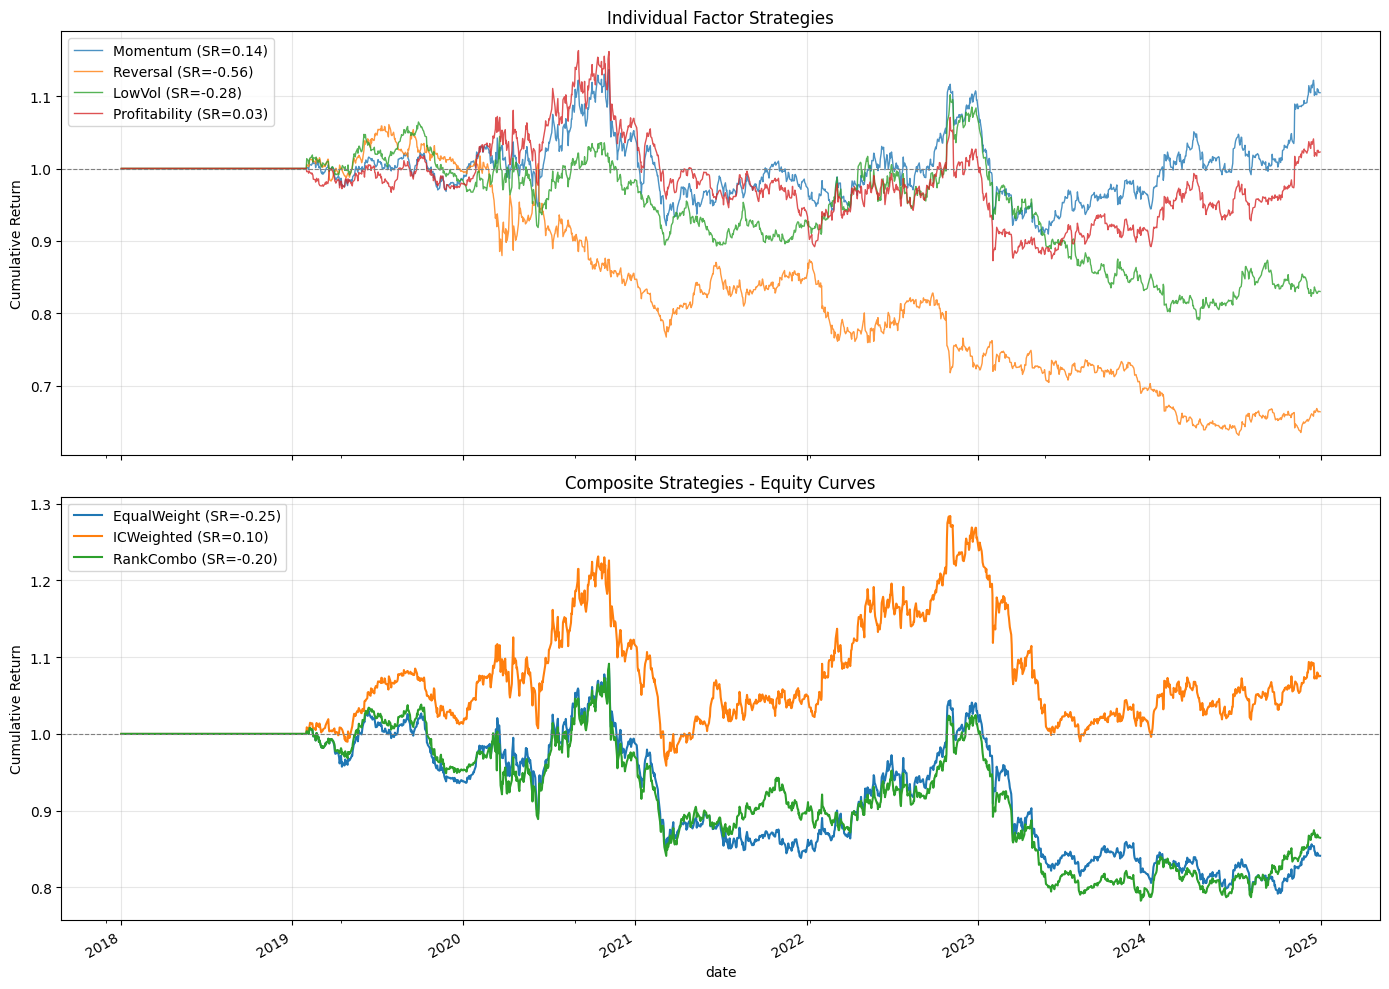

In [12]:
# Equity curves: individual strategies (top) and composites (bottom)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

colors_ind = {"Momentum": "#1f77b4", "Reversal": "#ff7f0e",
              "LowVol": "#2ca02c", "Profitability": "#d62728"}
for name, color in colors_ind.items():
    cum = (1 + results[name].portfolio_returns).cumprod()
    cum.plot(ax=ax1, label=f"{name} (SR={summaries[name]['sharpe_ratio']:.2f})",
             color=color, linewidth=1, alpha=0.8)
ax1.axhline(1.0, color="grey", linestyle="--", linewidth=0.8)
ax1.set_ylabel("Cumulative Return")
ax1.set_title("Individual Factor Strategies")
ax1.legend(loc="upper left")

colors_comp = {"EqualWeight": "#1f77b4", "ICWeighted": "#ff7f0e", "RankCombo": "#2ca02c"}
for name, color in colors_comp.items():
    cum = (1 + results[name].portfolio_returns).cumprod()
    cum.plot(ax=ax2, label=f"{name} (SR={summaries[name]['sharpe_ratio']:.2f})",
             color=color, linewidth=1.5)
ax2.axhline(1.0, color="grey", linestyle="--", linewidth=0.8)
ax2.set_ylabel("Cumulative Return")
ax2.set_title("Composite Strategies - Equity Curves")
ax2.legend(loc="upper left")

plt.tight_layout()
plt.show()

## 6. Marginal contribution — leave-one-out analysis

To assess each signal's **marginal contribution**, we build the equal-weight
composite *without* that signal and compare the Sharpe ratio to the full
composite.

- **Positive delta**: removing the signal *hurts* the composite (the signal adds value).
- **Negative delta**: removing the signal *helps* (the signal is a drag).

In [13]:
full_sharpe = summaries["EqualWeight"]["sharpe_ratio"]
loo_sharpes = {}
sharpe_deltas = {}

for drop_name in signal_names:
    remaining = [n for n in signal_names if n != drop_name]
    loo_sig = sum(signals[n] for n in remaining) / len(remaining)
    loo_sig = zscore(loo_sig.dropna())

    w = equal_weight_long_short(loo_sig, long_pct=0.2, short_pct=0.2)
    w = normalize_weights(w, gross_exposure=2.0, net_exposure=0.0)
    w = apply_position_limits(w, max_weight=0.10, min_weight=-0.10)
    res = run_backtest(w, prices, config=config)
    loo_sr = performance_summary(res.portfolio_returns)["sharpe_ratio"]
    loo_sharpes[drop_name] = loo_sr
    sharpe_deltas[drop_name] = full_sharpe - loo_sr
    print(f"  Drop {drop_name:15s}: LOO Sharpe={loo_sr:+.3f}  "
          f"Delta={sharpe_deltas[drop_name]:+.3f}")

print(f"\nFull EqualWeight composite Sharpe: {full_sharpe:+.3f}")

  Drop Momentum       : LOO Sharpe=-0.519  Delta=+0.271
  Drop Reversal       : LOO Sharpe=+0.011  Delta=-0.259
  Drop LowVol         : LOO Sharpe=+0.059  Delta=-0.307
  Drop Profitability  : LOO Sharpe=-0.404  Delta=+0.156

Full EqualWeight composite Sharpe: -0.248


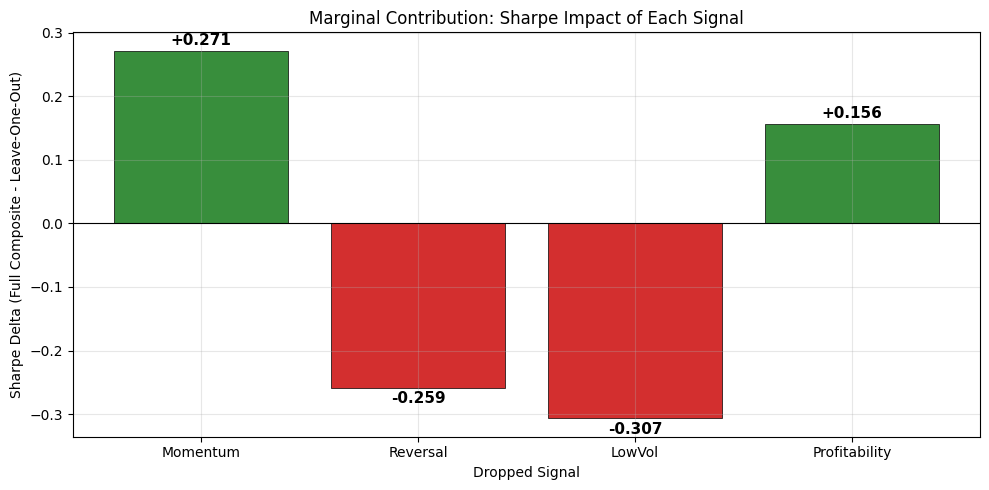

Green bars (positive delta) = signal adds value to the composite.
Red bars (negative delta) = signal detracts from the composite.


In [14]:
# Bar chart of Sharpe deltas
fig, ax = plt.subplots(figsize=(10, 5))
names = list(sharpe_deltas.keys())
deltas = list(sharpe_deltas.values())
colors = ["#388e3c" if d > 0 else "#d32f2f" for d in deltas]
bars = ax.bar(names, deltas, color=colors, edgecolor="black", linewidth=0.5)

for bar, delta in zip(bars, deltas):
    y = bar.get_height()
    offset = 0.005 if abs(y) > 0.01 else 0.002
    ax.text(bar.get_x() + bar.get_width() / 2, y + offset * np.sign(y),
            f"{delta:+.3f}", ha="center", va="bottom" if y >= 0 else "top",
            fontsize=11, fontweight="bold")

ax.axhline(0, color="black", linewidth=0.8)
ax.set_ylabel("Sharpe Delta (Full Composite - Leave-One-Out)")
ax.set_title("Marginal Contribution: Sharpe Impact of Each Signal")
ax.set_xlabel("Dropped Signal")
plt.tight_layout()
plt.show()

print("Green bars (positive delta) = signal adds value to the composite.")
print("Red bars (negative delta) = signal detracts from the composite.")

## 7. Correlation stability over time

Signal correlations are not static. We compute the **rolling 126-day
cross-sectional Spearman correlation** between the momentum and reversal
signals. Instability here is a risk for combination strategies that assume
fixed signal relationships.

In [15]:
# Rolling 126-day cross-sectional correlation: Momentum vs Reversal
roll_window = 126
rolling_corrs = []
rolling_corr_dates = []

for d_idx in range(roll_window, len(dates)):
    d = dates[d_idx]
    window_dates = dates[d_idx - roll_window:d_idx]
    corrs_window = []
    for wd in window_dates[::3]:  # subsample for speed
        try:
            s_m = signals["Momentum"].loc[wd].dropna()
            s_r = signals["Reversal"].loc[wd].dropna()
            common_t = s_m.index.intersection(s_r.index)
            if len(common_t) >= 5:
                rho, _ = spearmanr(s_m.loc[common_t].values,
                                   s_r.loc[common_t].values)
                if not np.isnan(rho):
                    corrs_window.append(rho)
        except Exception:
            continue
    if corrs_window:
        rolling_corrs.append(np.mean(corrs_window))
        rolling_corr_dates.append(d)

rolling_corr_series = pd.Series(rolling_corrs, index=rolling_corr_dates)
print(f"Rolling 126-day correlation (Momentum vs Reversal):")
print(f"  Mean:   {rolling_corr_series.mean():.3f}")
print(f"  Std:    {rolling_corr_series.std():.3f}")
print(f"  Min:    {rolling_corr_series.min():.3f}")
print(f"  Max:    {rolling_corr_series.max():.3f}")

Rolling 126-day correlation (Momentum vs Reversal):
  Mean:   -0.024
  Std:    0.123
  Min:    -0.250
  Max:    0.293


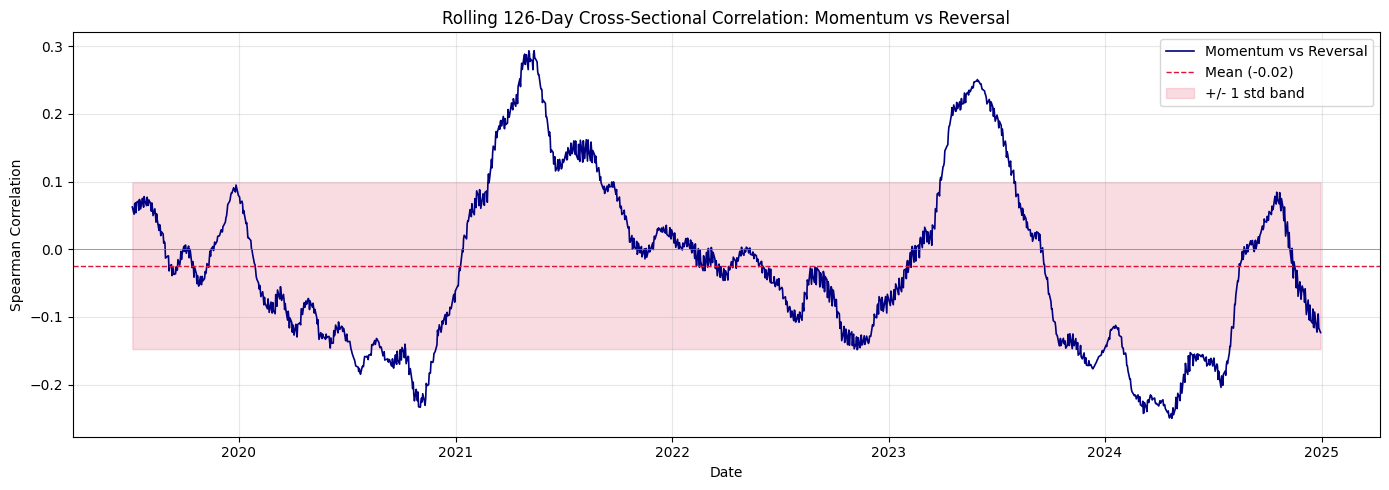


Stable correlation = reliable diversification benefit.
Wide swings = combination may fail when you need it most.


In [16]:
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(rolling_corr_series.index, rolling_corr_series.values,
        color="navy", linewidth=1.2, label="Momentum vs Reversal")
ax.axhline(rolling_corr_series.mean(), color="crimson", linestyle="--",
           linewidth=1, label=f"Mean ({rolling_corr_series.mean():.2f})")
ax.fill_between(rolling_corr_series.index,
                rolling_corr_series.mean() - rolling_corr_series.std(),
                rolling_corr_series.mean() + rolling_corr_series.std(),
                alpha=0.15, color="crimson", label="+/- 1 std band")
ax.axhline(0, color="grey", linewidth=0.5)
ax.set_ylabel("Spearman Correlation")
ax.set_xlabel("Date")
ax.set_title("Rolling 126-Day Cross-Sectional Correlation: Momentum vs Reversal")
ax.legend(loc="upper right")
plt.tight_layout()
plt.show()

print("\nStable correlation = reliable diversification benefit.")
print("Wide swings = combination may fail when you need it most.")

## 8. What can go wrong

### 8.1 Overfitting combination weights

Optimising signal weights on historical data is tempting but dangerous.
IC estimates are noisy; more complex optimisation (e.g. mean-variance on
signal returns) compounds estimation error. **Shrinkage toward equal weight**
is essential — we used 50% above, and even that may be too aggressive.

**Mitigations**: walk-forward estimation, heavy shrinkage, prefer rank-based
combination over z-score-based.

### 8.2 Common factor exposures

If multiple signals load on the same underlying factor (market beta, size,
sector), combining them does not truly diversify. The composite amplifies
hidden, unintended bets.

**Diagnostic**: regress composite returns on standard factor models. A small
alpha relative to large factor loadings means the composite is a factor bet
in disguise.

### 8.3 Correlation breakdown in stress

During market crises, cross-sectional correlations spike: all stocks move
together, all alpha signals lose dispersion simultaneously. The
diversification benefit of combining signals vanishes precisely when it
is needed most.

### 8.4 Signal interaction effects

Signals can interact non-linearly. A high-momentum, high-volatility stock
behaves very differently from a high-momentum, low-volatility stock. Simple
linear combinations miss these interactions. Conditional combination or
interaction terms can help but add overfitting risk.

## 9. Summary

In [17]:
# Final summary table
print("=" * 95)
print("MULTI-FACTOR COMPOSITION - FINAL SUMMARY")
print("=" * 95)
print(f"\nUniverse: {len(TICKERS)} US equities, {START} to {END}")
print(f"Signals: {', '.join(signal_names)}")
print(f"Average pairwise signal correlation: "
      f"{(corr_matrix.sum() - n_signals) / (n_signals * (n_signals - 1)):.3f}")
print()

cols = ["Ann. Return", "Ann. Vol", "Sharpe", "Max DD", "Type"]
print(summary_df[cols].to_string())
print()

# Best composite vs best individual
best_composite = summary_df.loc[summary_df["Type"] == "Composite", "Sharpe"].idxmax()
best_comp_sr = summary_df.loc[best_composite, "Sharpe"]
best_individual = summary_df.loc[summary_df["Type"] == "Individual", "Sharpe"].idxmax()
best_ind_sr = summary_df.loc[best_individual, "Sharpe"]
print(f"Best composite:  {best_composite} (Sharpe = {best_comp_sr:.3f})")
print(f"Best individual: {best_individual} (Sharpe = {best_ind_sr:.3f})")
print(f"Improvement:     {best_comp_sr - best_ind_sr:+.3f} Sharpe units")

MULTI-FACTOR COMPOSITION - FINAL SUMMARY

Universe: 20 US equities, 2018-01-01 to 2024-12-31
Signals: Momentum, Reversal, LowVol, Profitability
Average pairwise signal correlation: 0.138

               Ann. Return  Ann. Vol  Sharpe  Max DD        Type
Momentum            0.0144    0.1055  0.1361 -0.2004  Individual
Reversal           -0.0570    0.1012 -0.5629 -0.4047  Individual
LowVol             -0.0263    0.0935 -0.2813 -0.2825  Individual
Profitability       0.0032    0.1050  0.0308 -0.2497  Individual
EqualWeight        -0.0244    0.0986 -0.2479 -0.2707   Composite
ICWeighted          0.0105    0.1060  0.0986 -0.2287   Composite
RankCombo          -0.0206    0.1036 -0.1987 -0.2829   Composite

Best composite:  ICWeighted (Sharpe = 0.099)
Best individual: Momentum (Sharpe = 0.136)
Improvement:     -0.038 Sharpe units


### Key takeaways

| Concept | Takeaway |
|---------|----------|
| **Signal diversity** | Combine signals with low cross-sectional correlation |
| **Equal weight** | Hard to beat; robust baseline with no look-ahead bias |
| **IC weighting** | Modest improvement possible, but shrinkage is essential |
| **Rank-then-combine** | Robust to outliers; nonparametric and stable |
| **Marginal contribution** | Leave-one-out reveals which signals earn their place |
| **Correlation stability** | Signal relationships drift over time — monitor them |
| **Overfitting** | The fancier the combination, the higher the overfitting risk |